# Sheldon Complete Usage Analysis
## Monthly Statistics + User Details from MongoDB

**Analysis includes:**
- Monthly unique users and interactions
- Growth trends and patterns
- User details (name, role, clinics) from MongoDB
- Usage by role analysis

## Setup & Imports

In [ ]:
# Import all required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text
from pymongo import MongoClient
from bson.objectid import ObjectId
import os
from dotenv import load_dotenv
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✅ All libraries imported")

✅ All libraries imported


In [ ]:
# Load environment variables and setup connections
load_dotenv()

# MySQL connection
DATABASE_URL = os.getenv('MYSQL_DATABASE_URL')
if DATABASE_URL:
    DATABASE_URL = DATABASE_URL.replace('mysql+aiomysql://', 'mysql+pymysql://')
mysql_engine = create_engine(DATABASE_URL, echo=False, pool_pre_ping=True)

# MongoDB connection
MONGO_URI = os.getenv('MONGO_DATABASE_URI')
mongo_client = MongoClient(MONGO_URI)
mongo_db = mongo_client['UnifiedCare']
employees_collection = mongo_db['employees']
role_assignments_collection = mongo_db['role_assignments']

print("✅ MySQL connected")
print("✅ MongoDB connected")
print(f"   MongoDB Database: {mongo_db.name}")
print(f"   Collections: employees, role_assignments")

✅ MySQL connected
✅ MongoDB connected
   MongoDB Database: UnifiedCare
   Collections: employees, role_assignments


## Part 1: Monthly Statistics

In [ ]:
# Query monthly statistics for Sheldon
query_monthly = text("""
    SELECT
        DATE_FORMAT(timestamp, '%Y-%m') as month,
        DATE_FORMAT(timestamp, '%Y-%m-01') as month_date,
        COUNT(DISTINCT user_id) as unique_users,
        COUNT(*) as total_interactions,
        COUNT(DISTINCT session_id) as total_sessions,
        COUNT(DISTINCT patient_id) as unique_patients,
        AVG(total_tokens) as avg_tokens,
        SUM(total_tokens) as sum_tokens,
        AVG(llm_process_time) as avg_process_time,
        COUNT(DISTINCT DATE(timestamp)) as active_days
    FROM ai.chat_history
    WHERE action_type = 'Sheldon'
        AND timestamp >= '2024-01-01'
    GROUP BY DATE_FORMAT(timestamp, '%Y-%m'), DATE_FORMAT(timestamp, '%Y-%m-01')
    ORDER BY month
""")

print("🔄 Querying Sheldon monthly data...")

with mysql_engine.connect() as conn:
    df_monthly = pd.read_sql(query_monthly, conn)

# Convert month_date to datetime
df_monthly['month_date'] = pd.to_datetime(df_monthly['month_date'])

print(f"✅ Monthly data loaded: {len(df_monthly)} months found")
print(f"   Date range: {df_monthly['month'].min()} to {df_monthly['month'].max()}")
print()

# Display the data
display(df_monthly[['month', 'unique_users', 'total_interactions', 'total_sessions', 'sum_tokens', 'active_days']])

🔄 Querying Sheldon monthly data...
✅ Monthly data loaded: 15 months found
   Date range: 2024-09 to 2025-11



,month,unique_users,total_interactions,total_sessions,sum_tokens,active_days
0,2024-09,53,285,173,770920.0,23
1,2024-10,46,275,169,698329.0,26
2,2024-11,25,149,81,413878.0,20
3,2024-12,24,122,77,303295.0,21
4,2025-01,30,172,108,550692.0,24
5,2025-02,22,60,41,119258.0,11
6,2025-03,22,99,60,167033.0,20
7,2025-04,21,96,57,160655.0,21
8,2025-05,24,86,52,136407.0,20
9,2025-06,22,64,44,85072.0,17


In [ ]:
# Calculate growth metrics
df_monthly['user_growth'] = df_monthly['unique_users'].diff()
df_monthly['user_growth_pct'] = df_monthly['unique_users'].pct_change() * 100
df_monthly['interaction_growth'] = df_monthly['total_interactions'].diff()
df_monthly['interaction_growth_pct'] = df_monthly['total_interactions'].pct_change() * 100

print("📈 Monthly Growth Analysis:")
display(df_monthly[['month', 'unique_users', 'user_growth', 'user_growth_pct', 'total_interactions', 'interaction_growth', 'interaction_growth_pct']])

📈 Monthly Growth Analysis:


,month,unique_users,user_growth,user_growth_pct,total_interactions,interaction_growth,interaction_growth_pct
0,2024-09,53,NaN,NaN,285,NaN,NaN
1,2024-10,46,-7.0,-13.207547,275,-10.0,-3.508772
2,2024-11,25,-21.0,-45.652174,149,-126.0,-45.818182
3,2024-12,24,-1.0,-4.000000,122,-27.0,-18.120805
4,2025-01,30,6.0,25.000000,172,50.0,40.983607
5,2025-02,22,-8.0,-26.666667,60,-112.0,-65.116279
6,2025-03,22,0.0,0.000000,99,39.0,65.000000
7,2025-04,21,-1.0,-4.545455,96,-3.0,-3.030303
8,2025-05,24,3.0,14.285714,86,-10.0,-10.416667
9,2025-06,22,-2.0,-8.333333,64,-22.0,-25.581395


In [ ]:
# Summary statistics
print("=" * 70)
print("📊 SHELDON MONTHLY SUMMARY")
print("=" * 70)

print(f"\n📅 Time Period:")
print(f"   From: {df_monthly['month'].min()}")
print(f"   To: {df_monthly['month'].max()}")
print(f"   Total Months: {len(df_monthly)}")

print(f"\n👥 Users:")
print(f"   Peak Month: {df_monthly.loc[df_monthly['unique_users'].idxmax(), 'month']} ({df_monthly['unique_users'].max():,} users)")
print(f"   Lowest Month: {df_monthly.loc[df_monthly['unique_users'].idxmin(), 'month']} ({df_monthly['unique_users'].min():,} users)")
print(f"   Average per Month: {df_monthly['unique_users'].mean():,.0f} users")

print(f"\n💬 Interactions:")
print(f"   Peak Month: {df_monthly.loc[df_monthly['total_interactions'].idxmax(), 'month']} ({df_monthly['total_interactions'].max():,} interactions)")
print(f"   Average per Month: {df_monthly['total_interactions'].mean():,.0f} interactions")
print(f"   Total: {df_monthly['total_interactions'].sum():,} interactions")

print(f"\n📈 Growth:")
if len(df_monthly) > 1:
    first_month_users = df_monthly.iloc[0]['unique_users']
    last_month_users = df_monthly.iloc[-1]['unique_users']
    overall_growth = ((last_month_users - first_month_users) / first_month_users * 100) if first_month_users > 0 else 0
    print(f"   Overall User Growth: {overall_growth:+.1f}% (from {first_month_users:,.0f} to {last_month_users:,.0f})")
    avg_growth = df_monthly['user_growth_pct'].dropna().mean()
    print(f"   Average Monthly Growth: {avg_growth:.1f}%")

print(f"\n💰 Token Usage:")
print(f"   Total Tokens: {df_monthly['sum_tokens'].sum():,.0f}")
print(f"   Average per Month: {df_monthly['sum_tokens'].mean():,.0f} tokens")

print("\n" + "=" * 70)

📊 SHELDON MONTHLY SUMMARY

📅 Time Period:
   From: 2024-09
   To: 2025-11
   Total Months: 15

👥 Users:
   Peak Month: 2024-09 (53 users)
   Lowest Month: 2025-11 (9 users)
   Average per Month: 25 users

💬 Interactions:
   Peak Month: 2024-09 (285 interactions)
   Average per Month: 115 interactions
   Total: 1,728 interactions

📈 Growth:
   Overall User Growth: -83.0% (from 53 to 9)
   Average Monthly Growth: -8.0%

💰 Token Usage:
   Total Tokens: 3,829,636
   Average per Month: 255,309 tokens



## Visualizations

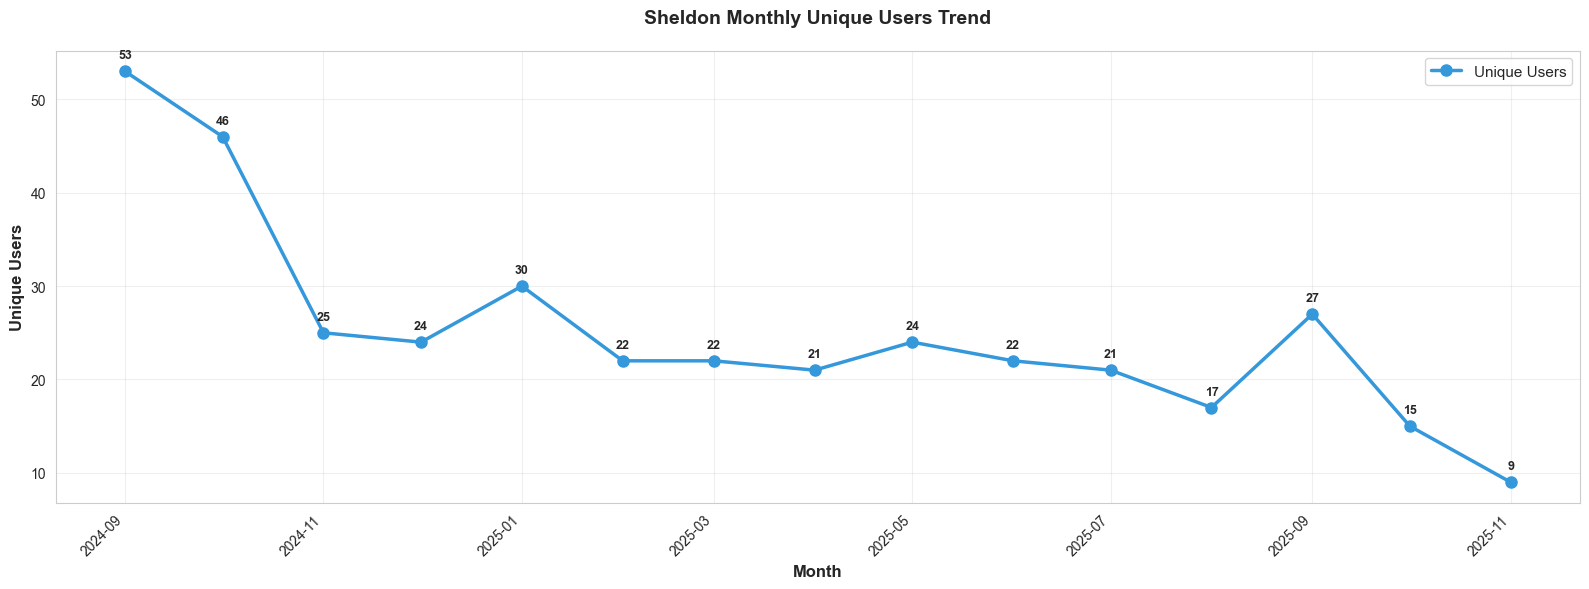

In [ ]:
# Chart: Monthly Unique Users Trend
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(df_monthly['month_date'], df_monthly['unique_users'], marker='o', linewidth=2.5, 
        markersize=8, color='#3498db', label='Unique Users')

# Add value labels
for idx, row in df_monthly.iterrows():
    ax.text(row['month_date'], row['unique_users'] + df_monthly['unique_users'].max() * 0.02,
            f"{int(row['unique_users']):,}",
            ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Month', fontweight='bold', fontsize=12)
ax.set_ylabel('Unique Users', fontweight='bold', fontsize=12)
ax.set_title('Sheldon Monthly Unique Users Trend', fontweight='bold', fontsize=14, pad=20)
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right', fontsize=11)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

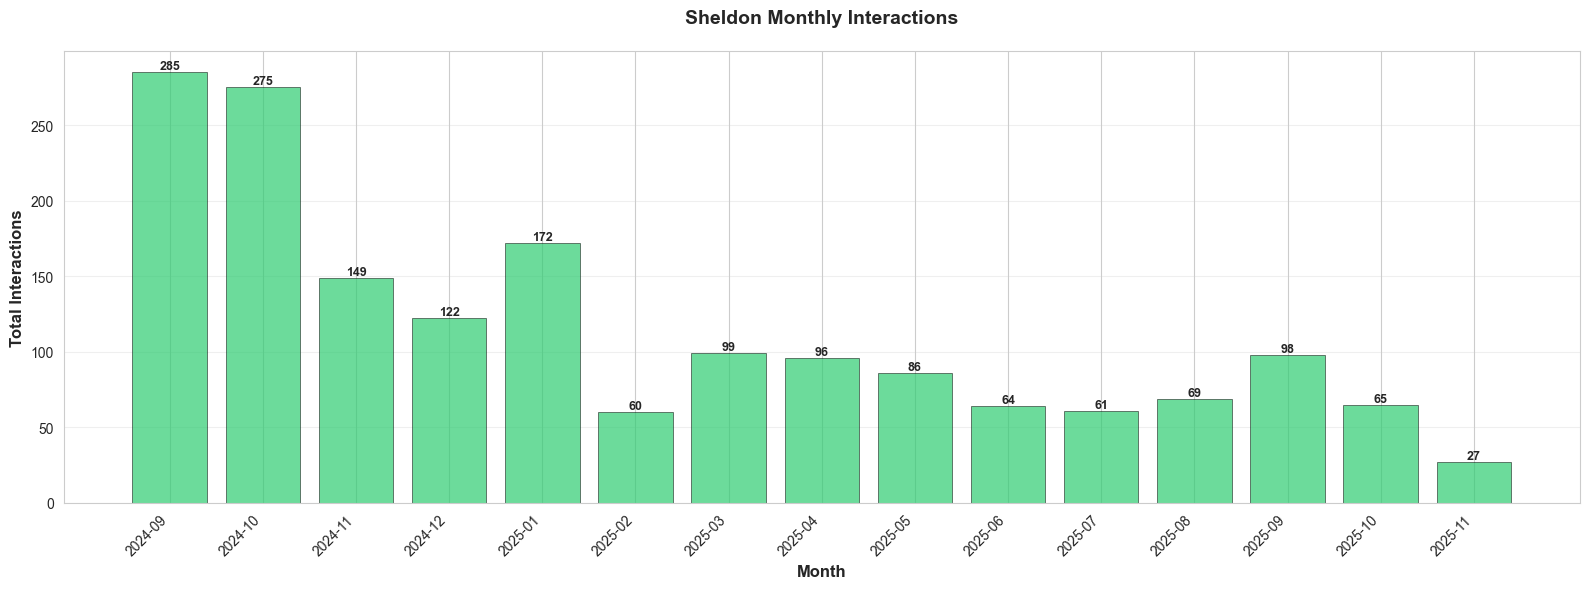

In [ ]:
# Chart: Monthly Interactions
fig, ax = plt.subplots(figsize=(16, 6))

bars = ax.bar(df_monthly['month'], df_monthly['total_interactions'], 
              color='#2ecc71', alpha=0.7, edgecolor='black', linewidth=0.5)

for bar in bars:
    height = bar.get_height()
    if height > 0:
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Month', fontweight='bold', fontsize=12)
ax.set_ylabel('Total Interactions', fontweight='bold', fontsize=12)
ax.set_title('Sheldon Monthly Interactions', fontweight='bold', fontsize=14, pad=20)
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

## Part 2: User Details from MongoDB

In [ ]:
# Get all unique user_ids from Sheldon usage
query_users = text("""
    SELECT DISTINCT user_id
    FROM ai.chat_history
    WHERE action_type = 'Sheldon'
        AND timestamp >= '2024-01-01'
    ORDER BY user_id
""")

with mysql_engine.connect() as conn:
    user_ids_df = pd.read_sql(query_users, conn)

print(f"📊 Found {len(user_ids_df)} unique Sheldon users")
print(f"\nSample user_ids:")
print(user_ids_df.head(10))

📊 Found 114 unique Sheldon users

Sample user_ids:
                    user_id
0                       456
1  5a02483ebfac836b19df4474
2  5b5269d346237d0012f1546f
3  5b99d686137d2500121f7236
4  5dc12503ea056a0013342a2f
5  5e39b9959e0528001499a7e0
6  5e7c31028ac8c40013343846
7  5e7e495df2668b001413fd16
8  5e8675eee6e87100129c91b4
9  5ed7dbaa7214b300139c9d8d


In [ ]:
# Function to get user details from MongoDB
def get_user_details(user_id_str):
    """Get user details from MongoDB employees and role_assignments collections"""
    try:
        user_obj_id = ObjectId(user_id_str)
        
        # Get user info from employees collection
        user_doc = employees_collection.find_one({"_id": user_obj_id})
        
        # Get roles from role_assignments collection
        role_docs = list(role_assignments_collection.find({"memberId": user_obj_id}))
        unique_roles = list(set([doc.get('roleType') for doc in role_docs if doc.get('roleType')]))
        roles_str = ', '.join(sorted(unique_roles)) if unique_roles else 'N/A'
        
        if user_doc:
            return {
                'user_id': user_id_str,
                'name': user_doc.get('name', {}).get('full', 'N/A'),
                'first_name': user_doc.get('name', {}).get('first', 'N/A'),
                'last_name': user_doc.get('name', {}).get('last', 'N/A'),
                'email': user_doc.get('email', 'N/A'),
                'roles': roles_str,
                'status': user_doc.get('status', 'N/A'),
                'title': user_doc.get('title', 'N/A')
            }
        else:
            return {
                'user_id': user_id_str,
                'name': 'Not Found',
                'first_name': 'N/A',
                'last_name': 'N/A',
                'email': 'N/A',
                'roles': roles_str if unique_roles else 'N/A',
                'status': 'N/A',
                'title': 'N/A'
            }
    except Exception as e:
        return {
            'user_id': user_id_str,
            'name': f'Error: {str(e)}',
            'first_name': 'N/A',
            'last_name': 'N/A',
            'email': 'N/A',
            'roles': 'N/A',
            'status': 'N/A',
            'title': 'N/A'
        }

# Test with one valid user
if len(user_ids_df) > 1:
    # Skip first one if it's not a valid ObjectId
    for idx in range(min(5, len(user_ids_df))):
        sample_user_id = user_ids_df.iloc[idx]['user_id']
        try:
            ObjectId(sample_user_id)
            print(f"Testing with user_id: {sample_user_id}\n")
            sample_user_info = get_user_details(sample_user_id)
            for key, value in sample_user_info.items():
                print(f"  {key}: {value}")
            break
        except:
            continue

print("\n✅ User details function ready (with role_assignments)")

Testing with user_id: 5a02483ebfac836b19df4474

  user_id: 5a02483ebfac836b19df4474
  name: N/A
  first_name: N/A
  last_name: N/A
  email: vivian.hou@ihealthlabs.com
  roles: RD
  status: ACTIVATED
  title: N/A

✅ User details function ready (with role_assignments)


In [ ]:
# Fetch all user details from MongoDB
print("🔄 Fetching user details from MongoDB...\n")

user_details_list = []
for idx, row in user_ids_df.iterrows():
    user_id = row['user_id']
    user_info = get_user_details(user_id)
    user_details_list.append(user_info)
    
    # Progress indicator
    if (idx + 1) % 10 == 0:
        print(f"   Processed {idx + 1}/{len(user_ids_df)} users...")

# Create DataFrame
users_info_df = pd.DataFrame(user_details_list)

print(f"\n✅ Retrieved information for {len(users_info_df)} users")
print(f"\nSample user information:")
display(users_info_df.head(10))

🔄 Fetching user details from MongoDB...

   Processed 10/114 users...
   Processed 20/114 users...
   Processed 30/114 users...
   Processed 40/114 users...
   Processed 50/114 users...
   Processed 60/114 users...
   Processed 70/114 users...
   Processed 80/114 users...
   Processed 90/114 users...
   Processed 100/114 users...
   Processed 110/114 users...

✅ Retrieved information for 114 users

Sample user information:


,user_id,name,first_name,last_name,email,roles,status,title
0,456,"Error: '456' is not a valid ObjectId, it must ...",N/A,N/A,N/A,N/A,N/A,N/A
1,5a02483ebfac836b19df4474,N/A,N/A,N/A,vivian.hou@ihealthlabs.com,RD,ACTIVATED,N/A
2,5b5269d346237d0012f1546f,N/A,N/A,N/A,leah.wang@ihealthlabs.com,RD,ACTIVATED,N/A
3,5b99d686137d2500121f7236,N/A,N/A,N/A,nina.ghamrawi@ihealthlabs.com,"ADMIN, RD, SUPER_ADMIN",ACTIVATED,N/A
4,5dc12503ea056a0013342a2f,N/A,N/A,N/A,grace.aguirre@ihealthlabs.com,RD,DEACTIVATED,N/A
5,5e39b9959e0528001499a7e0,N/A,N/A,N/A,claire.meng@ihealthlabs.com,"ADMIN, CA, HC, RD",ACTIVATED,N/A
6,5e7c31028ac8c40013343846,N/A,N/A,N/A,hanting.li@ihealthlabs.com,RD,ACTIVATED,N/A
7,5e7e495df2668b001413fd16,N/A,N/A,N/A,poureya.sohbati@ihealthlabs.com,"ADMIN, RD",ACTIVATED,N/A
8,5e8675eee6e87100129c91b4,N/A,N/A,N/A,ben.luu@ihealthlabs.com,N/A,DELETED,N/A
9,5ed7dbaa7214b300139c9d8d,N/A,N/A,N/A,vy.phung@ihealthlabs.com,"CA, HC",ACTIVATED,N/A


## Part 3: Merge Usage Stats with User Details

In [ ]:
# Get usage statistics per user
query_user_stats = text("""
    SELECT 
        user_id,
        COUNT(*) as total_interactions,
        COUNT(DISTINCT session_id) as total_sessions,
        MIN(timestamp) as first_use,
        MAX(timestamp) as last_use,
        COUNT(DISTINCT DATE_FORMAT(timestamp, '%Y-%m')) as active_months,
        SUM(total_tokens) as total_tokens
    FROM ai.chat_history
    WHERE action_type = 'Sheldon'
        AND timestamp >= '2024-01-01'
    GROUP BY user_id
    ORDER BY total_interactions DESC
""")

with mysql_engine.connect() as conn:
    user_stats_df = pd.read_sql(query_user_stats, conn)

# Merge with user info (removed assigned_clinics)
user_stats_with_info = user_stats_df.merge(
    users_info_df[['user_id', 'name', 'email', 'roles', 'title', 'status']], 
    on='user_id', 
    how='left'
)

print("📊 Top 20 Sheldon Users with Details:\n")
display(user_stats_with_info.head(20))

📊 Top 20 Sheldon Users with Details:



,user_id,total_interactions,total_sessions,first_use,last_use,active_months,total_tokens,name,email,roles,title,status
0,636ae19451ca690013861179,156,79,2024-09-13 19:35:40,2025-08-22 19:44:15,11,459796.0,N/A,sheena.bling@ihealthlabs.com,RD,N/A,ACTIVATED
1,66a9262c55a933735f9f9c0d,130,89,2024-09-09 21:58:55,2025-09-26 22:07:15,12,296258.0,N/A,maria.blandon@ihealthlabs.com,RD,N/A,ACTIVATED
2,65effe807274a0644f4fb6b5,78,46,2024-09-12 20:10:19,2025-10-14 00:19:35,12,133226.0,N/A,sandy.liang@ihealthlabs.com,CA,N/A,ACTIVATED
3,66b4007d495d86027459cd53,66,34,2024-09-24 22:42:13,2025-09-05 02:00:27,12,180155.0,N/A,yichen.sun@ihealthlabs.com,RD,N/A,ACTIVATED
4,62a314f7c474500013d78297,62,39,2024-09-06 02:17:40,2025-09-14 03:36:46,9,163616.0,N/A,timothy.mclerran@ihealthlabs.com,RD,N/A,ACTIVATED
5,65cc082efe78300013c61d65,57,29,2024-09-06 20:35:29,2025-09-24 22:43:52,11,110542.0,N/A,stephanie.refugio@ihealthlabs.com,CA,N/A,ACTIVATED
6,5f06172d300bbb0012e72143,54,33,2024-09-20 02:24:35,2025-10-29 23:13:59,8,82493.0,N/A,lunar.holiday@gmail.com,"CLINICAL_MANAGER, PROVIDER",N/A,ACTIVATED
7,6564f6d5f7a6bd00139fb3ff,51,25,2024-10-02 21:31:45,2025-11-03 17:38:51,11,122344.0,N/A,laiba.arshad@ihealthlabs.com,CA,N/A,ACTIVATED
8,6734f6dde456de2bab99e5ea,50,31,2024-11-20 22:22:28,2025-06-17 16:40:21,8,104726.0,N/A,katrina.dang@ihealthlabs.com,CA,N/A,ACTIVATED
9,66983f87193aa2047421b2be,49,16,2024-10-22 18:37:15,2025-10-13 20:37:19,7,181530.0,N/A,narry.hoeung@ihealthlabs.com,CA,N/A,ACTIVATED


In [ ]:
# Summary by roles
print("📋 Usage by Role:\n")
role_summary = user_stats_with_info.groupby('roles').agg({
    'user_id': 'count',
    'total_interactions': 'sum',
    'total_sessions': 'sum',
    'total_tokens': 'sum'
}).rename(columns={
    'user_id': 'user_count'
}).sort_values('total_interactions', ascending=False)

display(role_summary.head(15))

📋 Usage by Role:



,user_count,total_interactions,total_sessions,total_tokens
roles,,,,
RD,27,689,419,1671867.0
CA,29,582,333,1226496.0
HC,5,75,51,128297.0
"CA, HC",6,66,40,157456.0
"CLINICAL_MANAGER, PROVIDER",1,54,33,82493.0
N/A,6,41,35,73612.0
"HC, RD",3,34,26,88796.0
"CA, RD",3,29,18,49592.0
"ADMIN, RD",6,28,19,48447.0


In [ ]:
# Summary by status
print("📋 Usage by Status:\n")
status_summary = user_stats_with_info.groupby('status').agg({
    'user_id': 'count',
    'total_interactions': 'sum',
    'total_sessions': 'sum'
}).rename(columns={
    'user_id': 'user_count'
}).sort_values('total_interactions', ascending=False)

display(status_summary)

📋 Usage by Status:



,user_count,total_interactions,total_sessions
status,,,
ACTIVATED,89,1538,920
DEACTIVATED,19,149,89
DELETED,1,21,17
N/A,5,20,18


## Export Results

In [ ]:
# Export monthly statistics
output_monthly_csv = '/Users/sagegu/Documents/ai_data_analysis/sheldon_monthly_results.csv'
df_monthly.to_csv(output_monthly_csv, index=False)
print(f"✅ Monthly results exported to: {output_monthly_csv}")

# Export user statistics with details
output_users_csv = '/Users/sagegu/Documents/ai_data_analysis/sheldon_users_details.csv'
user_stats_with_info.to_csv(output_users_csv, index=False)
print(f"✅ User details exported to: {output_users_csv}")

# Export role summary
output_roles_csv = '/Users/sagegu/Documents/ai_data_analysis/sheldon_by_role.csv'
role_summary.to_csv(output_roles_csv)
print(f"✅ Role summary exported to: {output_roles_csv}")

print(f"\n📊 Summary:")
print(f"   Total months: {len(df_monthly)}")
print(f"   Total users: {len(user_stats_with_info)}")
print(f"   Total roles: {len(role_summary)}")

✅ Monthly results exported to: /Users/sagegu/Documents/ai_data_analysis/sheldon_monthly_results.csv
✅ User details exported to: /Users/sagegu/Documents/ai_data_analysis/sheldon_users_details.csv
✅ Role summary exported to: /Users/sagegu/Documents/ai_data_analysis/sheldon_by_role.csv

📊 Summary:
   Total months: 15
   Total users: 114
   Total roles: 24


## Cleanup

In [ ]:
# Export CA records for evaluation
output_ca_all = '/Users/sagegu/Documents/ai_data_analysis/sheldon_ca_all_records.csv'
ca_records_df.to_csv(output_ca_all, index=False)
print(f"✅ All CA records exported to: {output_ca_all}")

output_ca_with_answer = '/Users/sagegu/Documents/ai_data_analysis/sheldon_ca_with_answers.csv'
has_answer_df.to_csv(output_ca_with_answer, index=False)
print(f"✅ CA records with answers exported to: {output_ca_with_answer}")

if len(empty_answer_df) > 0:
    output_ca_empty = '/Users/sagegu/Documents/ai_data_analysis/sheldon_ca_empty_answers.csv'
    empty_answer_df.to_csv(output_ca_empty, index=False)
    print(f"✅ CA records with empty answers exported to: {output_ca_empty}")

print(f"\n📊 Ready for evaluation:")
print(f"   - {len(has_answer_df):,} CA records with complete Q&A pairs")
print(f"   - Dataset saved for evaluation process")